In [119]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
import plotly.express as px
import pickle
from genotype_encoder import hw_encoder

In [120]:
encoded_file = '../processed_data/training_{}.pkl'
encoded_test_file = '../processed_data/test_{}.pkl'
encoded_test_unique_env_file = '../processed_data/test_unique_env_{}.pkl'
encoded_val_file = '../processed_data/validation_{}.pkl'
cid_sid_dir = '../gid_cid_map/'
yield_dir = '../wheat_all/done/'
weather_cluster_file = '../processed_data/env_cluster.csv'
weather_file = '../iwin_weather/IWIN_Weather_AgERA5_20210211.txt'

In [121]:
versions = ['v1', 'v2', 'v3', 'v4', 'v5']

### Reading Training Data

In [122]:
def read_training_geno_data(encoded_file):
    '''
    This function takes the genotype file name as input and return the genotyped
    data. The genotyped data should be in pickle format
    '''
    data = pd.read_pickle(encoded_file)
#     print(data.shape)   
    
    return data

In [123]:
def read_gid_cid_map_file(cid_sid_dir):
    '''
    This function takes cid sid directory as the input
    and read the files that map GID with CID and SID
    '''
    all_gid_cid = pd.DataFrame()
    with os.scandir(cid_sid_dir) as prime_dir:
        for entry in prime_dir:
            x = pd.read_csv(entry)
            all_gid_cid = all_gid_cid.append(x, ignore_index = True)
    all_gid_cid['GID'] = 'GID' + all_gid_cid['GID'].astype('str')
    
    return all_gid_cid

In [124]:
def is_float(x):
    try:
        float(x)
    except ValueError:
        return False
    return True

In [125]:
def calc_average(x):
    x = np.array(x, dtype=float)
    avg = np.average(x)
    
    return avg

In [126]:
def read_yield_data(directory):
    
    yield_data = pd.DataFrame()
    with os.scandir(directory) as prime_dir:
        for entry in prime_dir:
            trial_name = entry.name
            yield_file = directory + trial_name + '/GrnYld.xls'
            x = pd.read_csv(yield_file, delimiter='\t')
            x['trial'] = trial_name
            yield_data = yield_data.append(x, ignore_index = True)
            
    yield_data = yield_data[yield_data.Value.apply(lambda x: is_float(x))]
    
    yield_data_groupby = yield_data.groupby(['Cid', 'Sid', 'Loc_no', 'trial', 'Cycle']).agg({
            'Value': lambda x: calc_average(x)
    })
    
    yield_data_groupby.reset_index(inplace=True)
    
    return yield_data_groupby

In [127]:
def map_data_with_cid(data, all_gid_cid):
    data_combined = all_gid_cid.merge(data, how='inner', on='GID')
    data_combined.drop_duplicates(inplace=True)
    
    return data_combined

In [128]:
def read_weather_cluster(weather_cluster_file):
    wd_cluster = pd.read_csv(weather_cluster_file)
    wd_cluster = wd_cluster[['location', 'cluster']]
    
    return wd_cluster

In [129]:
def merge_wd_yield_data(wd_cluster, yield_data):
    yield_data = yield_data.merge(wd_cluster, how='inner', left_on='Loc_no', right_on='location')
    yield_data.drop_duplicates(inplace=True)
    
    return yield_data

In [130]:
def calculate_avg_pheno(data_combined, yield_data):
    data_combined = data_combined[['GID', 'CID', 'SID']]
    yield_data = yield_data.merge(data_combined, left_on= ['Cid', 'Sid'], right_on=['CID', 'SID'], how='inner')
    yield_data = yield_data.groupby(['GID']).agg({
        'CID': lambda x: x.iloc[0],
        'SID': lambda x: x.iloc[0],
        'Value': lambda x: np.nanmean(x)
    })
    yield_data = yield_data.reset_index()
    return yield_data

In [131]:
def calculate_pheno_by_cluster(data_combined, yield_data):
    data_combined = data_combined[['GID', 'CID', 'SID']]
    yield_data = yield_data.merge(data_combined, left_on= ['Cid', 'Sid'], right_on=['CID', 'SID'], how='inner')
    yield_data = yield_data.groupby(['GID', 'cluster']).agg({
        'CID': lambda x: x.iloc[0],
        'SID': lambda x: x.iloc[0],
        'Value': lambda x: np.nanmean(x)
    })
    yield_data = yield_data.reset_index()
    return yield_data

In [132]:
def calculate_mi(data, target, num_features):
    features = data.columns
    mi = mutual_info_regression(data, target, discrete_features=True, random_state=5)
    
#     sorted_features = np.argsort(mi)[::-1][:num_features]
#     features = features[sorted_features]
    
    return features, mi

In [133]:
def find_all_local_features(data_combined, avg_pheno_by_cluster, num_features, global_features):
    
    clusters = np.unique(avg_pheno_by_cluster['cluster'].to_numpy())
    data_combined = data_combined.drop(global_features, axis=1)
    
    local_features_mi = np.zeros((data_combined.shape[1]-3, len(clusters)))
    i=0
    for cluster in clusters:
        cluster_avg = avg_pheno_by_cluster[avg_pheno_by_cluster['cluster']==cluster]
        x = cluster_avg.merge(data_combined, on=['CID', 'SID', 'GID'], how='inner')
        
        if x.shape[0] > 0:
            features, cluster_features = calculate_mi(x.drop(['GID', 'CID', 'SID', 'Value', 'cluster'], axis=1), x['Value'], num_features)
            local_features_mi[:,i] += cluster_features
        
        i+=1
    return local_features_mi, features
            

In [134]:
def plot_box_by_cluster(avg_pheno_by_cluster):
    avg_pheno_by_cluster = avg_pheno_by_cluster[avg_pheno_by_cluster['Value']<300]
    fig = px.box(avg_pheno_by_cluster, x='cluster', y='Value')
    fig.show()

In [135]:
def plot_box_by_env_within_cluster(yield_data, cluster_num):
    yield_data_by_cluster = yield_data[yield_data['cluster'] == cluster_num]
    yield_data_by_cluster['env'] = yield_data_by_cluster['trial'] + '_' + yield_data_by_cluster['Cycle'].astype(str)
    
    fig = px.box(yield_data_by_cluster, x='env', y='Value', title='Environment within cluster ' + str(cluster_num))
    fig.show()

In [136]:

hws = []
for version in versions:
    tr_file = encoded_file.format(version)
    data = read_training_geno_data(tr_file)
    
    gids = data['GID'].tolist()
    columns = data.drop(['GID'], axis=1).columns
    data_hw = data.drop(['GID'], axis=1)
    hw = hw_encoder(1, -1, 0)
    
    hw.fit(data_hw)
    hws.append(hw)


In [137]:
data.shape

(2249, 40768)

In [138]:
hw = hw_encoder(1, -1, 0)
for i, version in enumerate(versions):
    hw.p_square += hws[i].p_square
    hw.q_square += hws[i].q_square
    hw._2pq += hws[i]._2pq

hw.p_square = hw.p_square / len(versions)
hw.q_square = hw.q_square / len(versions)
hw._2pq = hw._2pq / len(versions)

In [139]:
hw.p_square

1A_1145442      0.755102
1A_1158042      0.708936
1A_1158055      0.887238
1A_1230946      0.940358
1A_1232964      0.969644
                  ...   
UN_474767314    0.421909
UN_475092207    0.516893
UN_475092295    0.542324
UN_476929267    0.988031
UN_476929292    0.988827
Length: 40767, dtype: float64

In [140]:
for version in versions:
    print('current file:',version)
    file = encoded_file.format(version)
    data = read_training_geno_data(file)
    
    gids = data['GID'].tolist()
    columns = data.drop(['GID'], axis=1).columns
    data_hw = data.drop(['GID'], axis=1)
#     hw = hw_encoder(1, -1, 0)
    data_hw = hw.transform(data_hw)
    data_hw['GID'] = gids
    data = data_hw
    
    data_hw.to_pickle('../hw_training_' + version + '.pkl')
    
    file = encoded_test_file.format(version)
    data = read_training_geno_data(file)
    
    gids = data['GID'].tolist()
    columns = data.drop(['GID'], axis=1).columns
    data_hw = data.drop(['GID'], axis=1)
#     hw = hw_encoder(1, -1, 0)
    data_hw = hw.transform(data_hw)
    data_hw['GID'] = gids
    data = data_hw
    
    data_hw.to_pickle('../hw_test_' + version + '.pkl')
    
    
    file = encoded_val_file.format(version)
    data = read_training_geno_data(file)
    
    gids = data['GID'].tolist()
    columns = data.drop(['GID'], axis=1).columns
    data_hw = data.drop(['GID'], axis=1)
#     hw = hw_encoder(1, -1, 0)
    data_hw = hw.transform(data_hw)
    data_hw['GID'] = gids
    data = data_hw
    
    data_hw.to_pickle('../hw_val_' + version + '.pkl')
    
    
    file = encoded_test_unique_env_file.format(version)
    data = read_training_geno_data(file)
    
    gids = data['GID'].tolist()
    columns = data.drop(['GID'], axis=1).columns
    data_hw = data.drop(['GID'], axis=1)
#     hw = hw_encoder(1, -1, 0)
    data_hw = hw.transform(data_hw)
    data_hw['GID'] = gids
    data = data_hw
    
    data_hw.to_pickle('../hw_test_unique_env_' + version + '.pkl')

current file: v1
current file: v2
current file: v3
current file: v4
current file: v5


In [141]:
all_mi_global = 0
for version in versions:
    data = pd.read_pickle('../hw_training_' + version + '.pkl')
    
    # file = encoded_test_file.format(version)
    # data = read_training_geno_data(file)
    
    
    all_gid_cid = read_gid_cid_map_file(cid_sid_dir)
    all_gid_cid.head()
    
    data_combined = map_data_with_cid(data, all_gid_cid)
    data_combined.head()
    
    yield_data = read_yield_data(yield_dir)
    
    
    with open('../processed_data/train_test_by_env_'+version+'.pkl', 'rb') as outfile:
        train_test_by_env = pickle.load(outfile)
    print('after train test')
    
    trials = train_test_by_env[train_test_by_env['training']==True]['index'].tolist()
    yield_data = yield_data[yield_data['trial'].isin(trials)]
    
    wd_cluster = read_weather_cluster(weather_cluster_file)
    
    yield_data = merge_wd_yield_data(wd_cluster, yield_data)
    
    avg_pheno_yield = calculate_avg_pheno(data_combined, yield_data)
    
    
    x = avg_pheno_yield.merge(data_combined, on=['CID', 'SID', 'GID'], how='inner')
    features, mi = calculate_mi(x.drop(['GID', 'CID', 'SID', 'Value'], axis=1), x['Value'], 2000)
    all_mi_global = all_mi_global + mi
    
#     local_features = find_all_local_features(data_combined, avg_pheno_by_cluster, 200, global_features)
#     all_mi_local = all_mi_local + local_features

all_mi_global = np.argsort(all_mi_global)[::-1][:2000]
global_features = features[all_mi_global]

after train test
after train test
after train test
after train test
after train test


In [142]:
global_features

Index(['2A_15449240', '2A_18359259', '2A_2800711', '2B_5042248', '2A_18058916',
       '2A_4942949', '3B_261620049', '2A_17830617', '2A_16881506',
       '2A_2367215',
       ...
       '5A_458325873', '3D_355163225', '7B_581344281', '6A_613332311',
       '5D_158833548', '7B_490357405', '5B_243931840', '2B_797272956',
       '2A_292805492', '1B_614500790'],
      dtype='object', length=2000)

In [143]:
all_mi_local = 0
for version in versions:
    data = pd.read_pickle('../hw_training_' + version + '.pkl')
    
    file = encoded_test_file.format(version)
    data = read_training_geno_data(file)
    
    
    all_gid_cid = read_gid_cid_map_file(cid_sid_dir)
    all_gid_cid.head()
    
    data_combined = map_data_with_cid(data, all_gid_cid)
    data_combined.head()
    
    yield_data = read_yield_data(yield_dir)
    
    
    with open('../processed_data/train_test_by_env_'+version+'.pkl', 'rb') as outfile:
        train_test_by_env = pickle.load(outfile)
    print('after train test')
    
    trials = train_test_by_env[train_test_by_env['training']==True]['index'].tolist()
    yield_data = yield_data[yield_data['trial'].isin(trials)]
    
    wd_cluster = read_weather_cluster(weather_cluster_file)
    
    yield_data = merge_wd_yield_data(wd_cluster, yield_data)
    
    avg_pheno_by_cluster = calculate_pheno_by_cluster(data_combined, yield_data)
    
    
    local_features_mi, features = find_all_local_features(data_combined, avg_pheno_by_cluster, 200, global_features)
    all_mi_local = all_mi_local + local_features_mi



after train test
after train test
after train test
after train test
after train test


In [144]:
features

Index(['1A_1145442', '1A_1158042', '1A_1158055', '1A_1230946', '1A_1232964',
       '1A_1236254', '1A_1238074', '1A_1238114', '1A_1588248', '1A_1698908',
       ...
       'UN_473655057', 'UN_473655073', 'UN_474138840', 'UN_474138845',
       'UN_474138866', 'UN_474767314', 'UN_475092207', 'UN_475092295',
       'UN_476929267', 'UN_476929292'],
      dtype='object', length=38767)

In [145]:
local_features = []
features = np.array(features)
for i in range(all_mi_local.shape[1]):
    mi_local = all_mi_local[:, i]
    mi_local = np.argsort(mi_local)[::-1][:100]
    
    local_features += list(features[mi_local])
    
local_features = list(set(local_features))

In [146]:
len(local_features)

2052

In [147]:
# all_gid_cid = read_gid_cid_map_file(cid_sid_dir)
# all_gid_cid.head()

In [148]:
# data_combined = map_data_with_cid(data, all_gid_cid)
# data_combined.head()

In [149]:
# yield_data = read_yield_data(yield_dir)
# yield_data.head()

In [150]:
# wd_cluster = read_weather_cluster(weather_cluster_file)
# wd_cluster.head()

In [151]:
# yield_data = merge_wd_yield_data(wd_cluster, yield_data)


In [152]:
# yield_data.head()

In [153]:
# avg_pheno_yield = calculate_avg_pheno(data_combined, yield_data)

In [154]:
# avg_pheno_by_cluster = calculate_pheno_by_cluster(data_combined, yield_data)

In [155]:
# x = avg_pheno_yield.merge(data_combined, on=['CID', 'SID', 'GID'], how='inner')

In [156]:
# x.head()

In [157]:
# global_features = calculate_mi(x.drop(['GID', 'CID', 'SID', 'Value'], axis=1), x['Value'], 2000)

In [158]:
# global_features = global_features.tolist()

In [159]:
# avg_pheno_by_cluster.head()

In [160]:
# local_features = find_all_local_features(data_combined, avg_pheno_by_cluster, 200, global_features)

In [161]:
# local_features = list(set(local_features))

In [162]:
# print(len(local_features))

In [167]:
all_features = global_features.tolist() + local_features

In [168]:
with open('../processed_data/selected_features_val.pkl', 'wb') as wfile:
    pickle.dump(all_features, wfile)

In [169]:
print(len(all_features))

4052


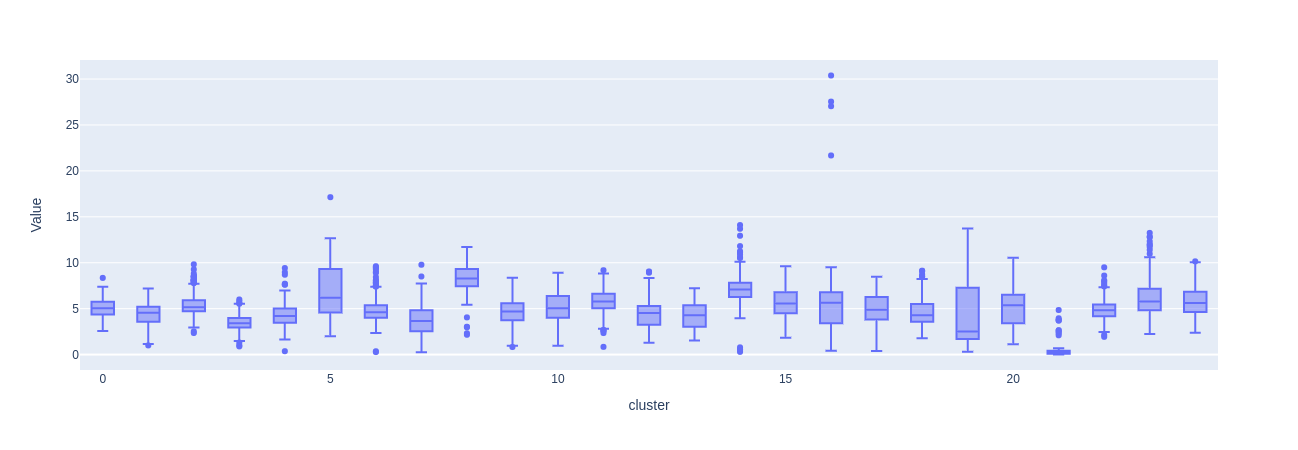

In [170]:
plot_box_by_cluster(avg_pheno_by_cluster)

<ipython-input-135-9f085392abd0>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



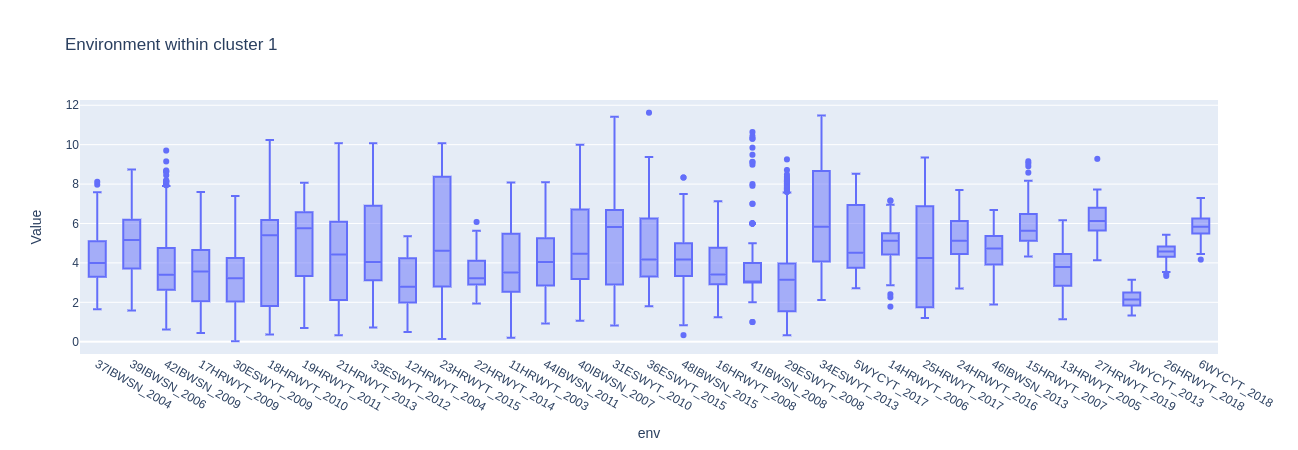

In [171]:
plot_box_by_env_within_cluster(yield_data, 1)

In [ ]:
# test_data = read_training_geno_data(encoded_test_file)

In [ ]:
# test_data

In [ ]:
# gids = test_data['GID']
# test_data = hw.transform(test_data.drop(['GID'], axis=1))
# test_data['GID'] = gids

In [172]:
for version in versions:
    tr_data = pd.read_pickle('../hw_training_' + version + '.pkl')
    tr_data = tr_data[['GID'] + all_features]
    tr_data = map_data_with_cid(tr_data, all_gid_cid)
    tr_data.to_pickle('../processed_data/feature_selected_training_'+version+'.pkl')
    
    test_data = pd.read_pickle('../hw_test_' + version + '.pkl')
    test_data = test_data[['GID'] + all_features]
    test_data = map_data_with_cid(test_data, all_gid_cid)
    test_data.to_pickle('../processed_data/feature_selected_test_'+version+'.pkl')
    
    test_data = pd.read_pickle('../hw_test_unique_env_' + version + '.pkl')
    test_data = test_data[['GID'] + all_features]
    test_data = map_data_with_cid(test_data, all_gid_cid)
    test_data.to_pickle('../processed_data/feature_selected_unique_env_'+version+'.pkl')
    
    val_data = pd.read_pickle('../hw_val_' + version + '.pkl')
    val_data = val_data[['GID'] + all_features]
    val_data = map_data_with_cid(val_data, all_gid_cid)
    val_data.to_pickle('../processed_data/feature_selected_validation_'+version+'.pkl')

In [ ]:
# tr_data = data[['GID'] + all_features]
# tr_data = map_data_with_cid(tr_data, all_gid_cid)

In [ ]:
# tr_data.to_pickle('../processed_data/feature_selected_training.pkl')

In [ ]:
# test_data = test_data[['GID'] + all_features]
# test_data = map_data_with_cid(test_data, all_gid_cid)

In [ ]:
# test_data.to_pickle('../processed_data/feature_selected_test.pkl')

In [ ]:
# val_data = read_training_geno_data(encoded_val_file)

In [ ]:
# gids = val_data['GID']
# val_data = hw.transform(val_data.drop(['GID'], axis=1))
# val_data['GID'] = gids

In [ ]:
# val_data = val_data[['GID'] + all_features]
# val_data = map_data_with_cid(val_data, all_gid_cid)

In [ ]:
# val_data.to_pickle('../processed_data/feature_selected_validation.pkl')